In [1]:
import gym

import torch
import numpy as np
from torch import nn
import torch.nn.functional as F

from torch.optim import Adam as Optimizer

In [2]:
class Actor(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_size = 4
        self.dim1 = 50
        self.dim2 = 50
        self.dimf = 50
        self.output_size = 2
        
        # Actor
        self.X = nn.Linear(self.input_size, self.dim1)
        self.X1 = nn.Linear(self.dim1, self.dim2)
        self.X2 = nn.Linear(self.dim2, self.dimf)
        self.Xf = nn.Linear(self.dimf, self.output_size)        
    
    def forward(self, observation):
        
        x = F.relu(self.X(observation))
        x = F.relu(self.X1(x))
        x = F.relu(self.X2(x))
        x = self.Xf(x)
        prob = F.softmax(x,dim=0)
        
        return prob

In [30]:
del actor

# Instances
env = gym.make('CartPole-v1')
actor = Actor()
optimizer = Optimizer(actor.parameters(), lr=1e-3)

# settings
epi = 10000
time = 500
store_episode = -torch.ones(epi)

# Roll-out
for i_episode in range(epi):
    
    store_log_prob = torch.zeros(time)
    observation = env.reset()[0]
    
    for t in range(time):
        
        # action by actor
        observation = torch.from_numpy(observation)
        prob = actor.forward(observation)
        action = prob.multinomial(num_samples=1).item()
        prob_select = prob[action]
        store_log_prob[t] = prob_select.log()

        # next state
        observation, reward, done, _, _ = env.step(action)
        
        if done:
            break

    if i_episode %200 ==0:
        print(("Episode finished after {} timesteps".format(t+1)))
    
    store_episode[i_episode] = t+1

    # training
    Gt = torch.tensor([ (1-0.99**(t-i))/(1-0.99) for i in range(t)])
    log_prob = store_log_prob[0:t]
    
    loss = -(Gt*log_prob).sum()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
env.close()

del actor, optimizer

Episode finished after 41 timesteps
Episode finished after 27 timesteps
Episode finished after 33 timesteps
Episode finished after 160 timesteps
Episode finished after 144 timesteps
Episode finished after 142 timesteps
Episode finished after 162 timesteps
Episode finished after 99 timesteps
Episode finished after 128 timesteps
Episode finished after 186 timesteps
Episode finished after 370 timesteps
Episode finished after 127 timesteps
Episode finished after 113 timesteps
Episode finished after 34 timesteps
Episode finished after 182 timesteps
Episode finished after 337 timesteps
Episode finished after 500 timesteps
Episode finished after 163 timesteps
Episode finished after 259 timesteps
Episode finished after 157 timesteps
Episode finished after 135 timesteps
Episode finished after 97 timesteps
Episode finished after 101 timesteps
Episode finished after 94 timesteps
Episode finished after 122 timesteps
Episode finished after 130 timesteps
Episode finished after 109 timesteps
Episode 

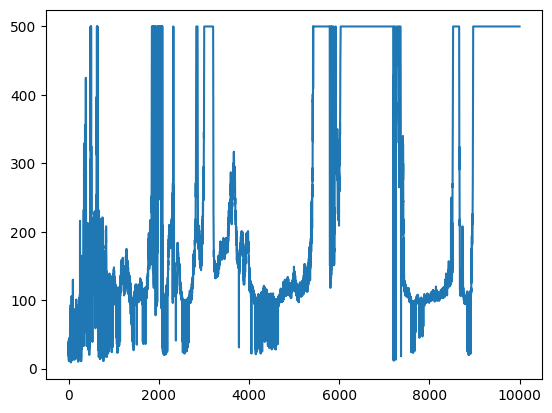

In [45]:
import matplotlib.pyplot as plt

x = np.arange(0,i_episode)
y = store_episode[0:i_episode].numpy()

fig, ax = plt.subplots()
ax.plot(x,y)

In [46]:
torch.save(store_episode[0:i_episode], "REINFORCE_result")